In [17]:
import mne                                                              # Librería de python para explorar, visualizar,
mne.set_log_level('WARNING')                                            # y analizar datos neurofisiológicos humanos.
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb                                                    
color = ['green', 'blue','red','cyan', 'magenta', 'yellow','k','w']     # Paleta de colores para diferenciar las ondas

import a_funciones as a_fun                                             # Funciones Alex

xlabel = 'Muestra'                                                      # Abscisas
ylabel = 'Amplitud (uV)'                                                # Ordenadas

import random

In [44]:
#-----------------------------------------------------------------------
# Carga de todos los archivos y ejecución de DrigSignal con 
# el vector aleatorio de templates ERP alterados en amplitud.
#-----------------------------------------------------------------------
# First load the template.  This is the signal that will be used to DRUG the basal EEG stream.
mat = scipy.io.loadmat('./dataset/ERPTemplate.mat')

routput = mat['routput']

# In this ERPTemplate, there are two different template signals that are good.
erptemplate1 = routput[0][7][0][1][0][0][0][7] 
erptemplate2 = routput[0][7][0][1][0][0][0][0] 

# The original ERPTemplate dataset has a sampling frequency of 256 so I need to perform a small downsampling to 250 Hz
erptemplate1 = np.delete( erptemplate1, range(0,256,43),0)
erptemplate2 = np.delete( erptemplate2, range(0,256,43),0)

# Use this for testing  (get a ZERO signal)
#erptemplate1 = np.zeros((250,8))

# np.save('./dataset/ERPTemplate.mat/array_DrugAmpERPtemplate.npy', array_DrugAmpERPtemplate)
array_DrugAmpERPtemplate = np.load('./dataset/array_DrugAmpERPtemplate.npy', allow_pickle=True)
len_array_DrugAmpERPtemplate = np.arange(0,len(array_DrugAmpERPtemplate))
# print("Tamaño del vector array_DrugAmpERPtemplate", len_array_DrugAmpERPtemplate)

# Randomize amplitude and jitter.
# Find the right locations where this should be inserted in the stream.
# Insert the signal mantaining the continiuity of the EEG.
def DrugSignal(signal, t_flash):
    '''
    Randomize amplitude and jitter
    Find the right locations where this should be inserted in the stream
    Insert the template mantaining the continuity and physiological meaning of the EEG
    '''
    for i in range(0,4200):
        if (t_flash[i,3]==2):
            random_DrugAmpERPtemplate = random.choice(len_array_DrugAmpERPtemplate)
            #print("Valor aleatorio seleccionado:", random_DrugAmpERPtemplate)
            signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (array_DrugAmpERPtemplate[random_DrugAmpERPtemplate])
            #print("array_DrugAmpERPtemplate:", array_DrugAmpERPtemplate[random_DrugAmpERPtemplate])
    return signal

# Now load the basal EEG stream
#mat = scipy.io.loadmat('./dataset/p300-subject-25.mat')
mat = scipy.io.loadmat('./dataset/itba/P300S01.mat')
#mat = scipy.io.loadmat('./dataset/p300-subject-26.mat')
#mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-21.mat')
#mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-06.mat')

# In[1]:

# coding: latin-1
# Data point zero for the eight channels.  Should be in V.
signal = mat['data'][0][0][0] 
#* pow(10,6)

# Trials
t_trials = mat['data'][0][0][3]

# Flash matrix
t_flash = mat['data'][0][0][4]

signal = DrugSignal(signal, t_flash)

t_stim = mat['data'][0][0][2]
t_type = mat['data'][0][0][1]

#-----------------------------------------------------------------------
# Encuentro de eventos
#-----------------------------------------------------------------------

ch_names=['Fz','Cz','P3','Pz','P4','PO7','PO8', 'Oz']                   # Los nombres de los canales
ch_types= ['eeg'] * signal.shape[1]                                     # Un vector de tamaño 8 con el'eeg' repetido
ch_names_events = ch_names + ['t_stim']+ ['t_type']                     # Le agrega  't_stim' y't_type' 
ch_types_events = ch_types + ['misc'] + ['misc']                        # Le agrega dos 'misc': 
                                                                        # Channel types, default is 'misc' which is not a data channel. 
                                                                        # Currently supported fields are ‘ecg’, ‘bio’, ‘stim’, ‘eog’, ‘misc’, 
                                                                        # ‘seeg’, ‘dbs’, ‘ecog’, ‘mag’, ‘eeg’, ‘ref_meg’, ‘grad’, ‘emg’, ‘hbr’ or ‘hbo’. 
                                                                        # If str, then all channels are assumed to be of the same type.
#info = mne.create_info(ch_names, 250, ch_types=ch_types)
#eeg_mne = mne.io.array.RawArray(signal.T, info)

signal_events = np.concatenate([signal, t_stim, t_type],1)              # Se agrega a la señal drogada 't_stim' y 't_type'

df_signal_events = a_fun.to_df(signal_events)
ch_names_events_with_sample = ch_names_events + ['sample']
df_signal_events.columns = ch_names_events_with_sample

info_events = mne.create_info(ch_names_events,250, ch_types_events)     # Acá crea los eventos. 
eeg = mne.io.RawArray(signal_events.T, info_events)                     # El objeto en crudo.

# Do some basic signal processing (1-20 band pass filter)
# *** fig=eeg.plot_psd()
eeg.filter(1,20)
# *** fig=eeg.plot_psd()
event_times = mne.find_events(eeg, stim_channel='t_type')    
# *** eeg.plot(scalings='auto',n_channels=8,events=event_times,block=True)   # scalings=10e-05

#========================================================================
# ChatGPT:
# Primero, verifica si la cantidad de valores únicos en la primera columna de la matriz es igual a 4200. 
# Si no es así, entonces el código busca valores duplicados en la primera columna de la matriz 
# y disminuye el valor de la fila correspondiente en 1 y establece el valor de la columna 1 en 1. 
# Luego, establece los valores de las columnas 2 y 3 de la matriz t_type y t_stim según los valores
# correspondientes de la columna 3 y 2 de la matriz t_flash.
# En la última línea del código, se utiliza la función assert para asegurarse de que la cantidad de valores únicos en la primera columna de la matriz t_flash sea igual a 4200. Si no lo es, se imprimirá un mensaje de error indicando que hay un problema con la estructura del experimento.

if (np.unique(t_flash[:,0]).shape[0] != 4200):                          # evalúa si el "sample point id" de t_flash tiene el tamaño correcto.
    u,c = np.unique( t_flash[:,0], return_counts=True)                  # u->Los elementos únicos. c->la cantidad de veces que se repiten.
    dup = u[c>1]                                                        # dup->Los que estén repetidos mas de una vez.    
    
    for i in range(dup.shape[0]):
        idx = np.where( t_flash[:,0] == dup[i] )[0][0]
        t_flash[idx,0]  -= 1
        t_flash[idx,1]  = 1
        t_type[t_flash[idx,0]] = t_flash[idx,3]
        t_stim[t_flash[idx,0]] = t_flash[idx,2]

np.unique(t_flash[:,0]).shape
assert  np.unique(t_flash[:,0]).shape[0] == 4200, 'Problem with experiment structure.  There aren''t enough events.'

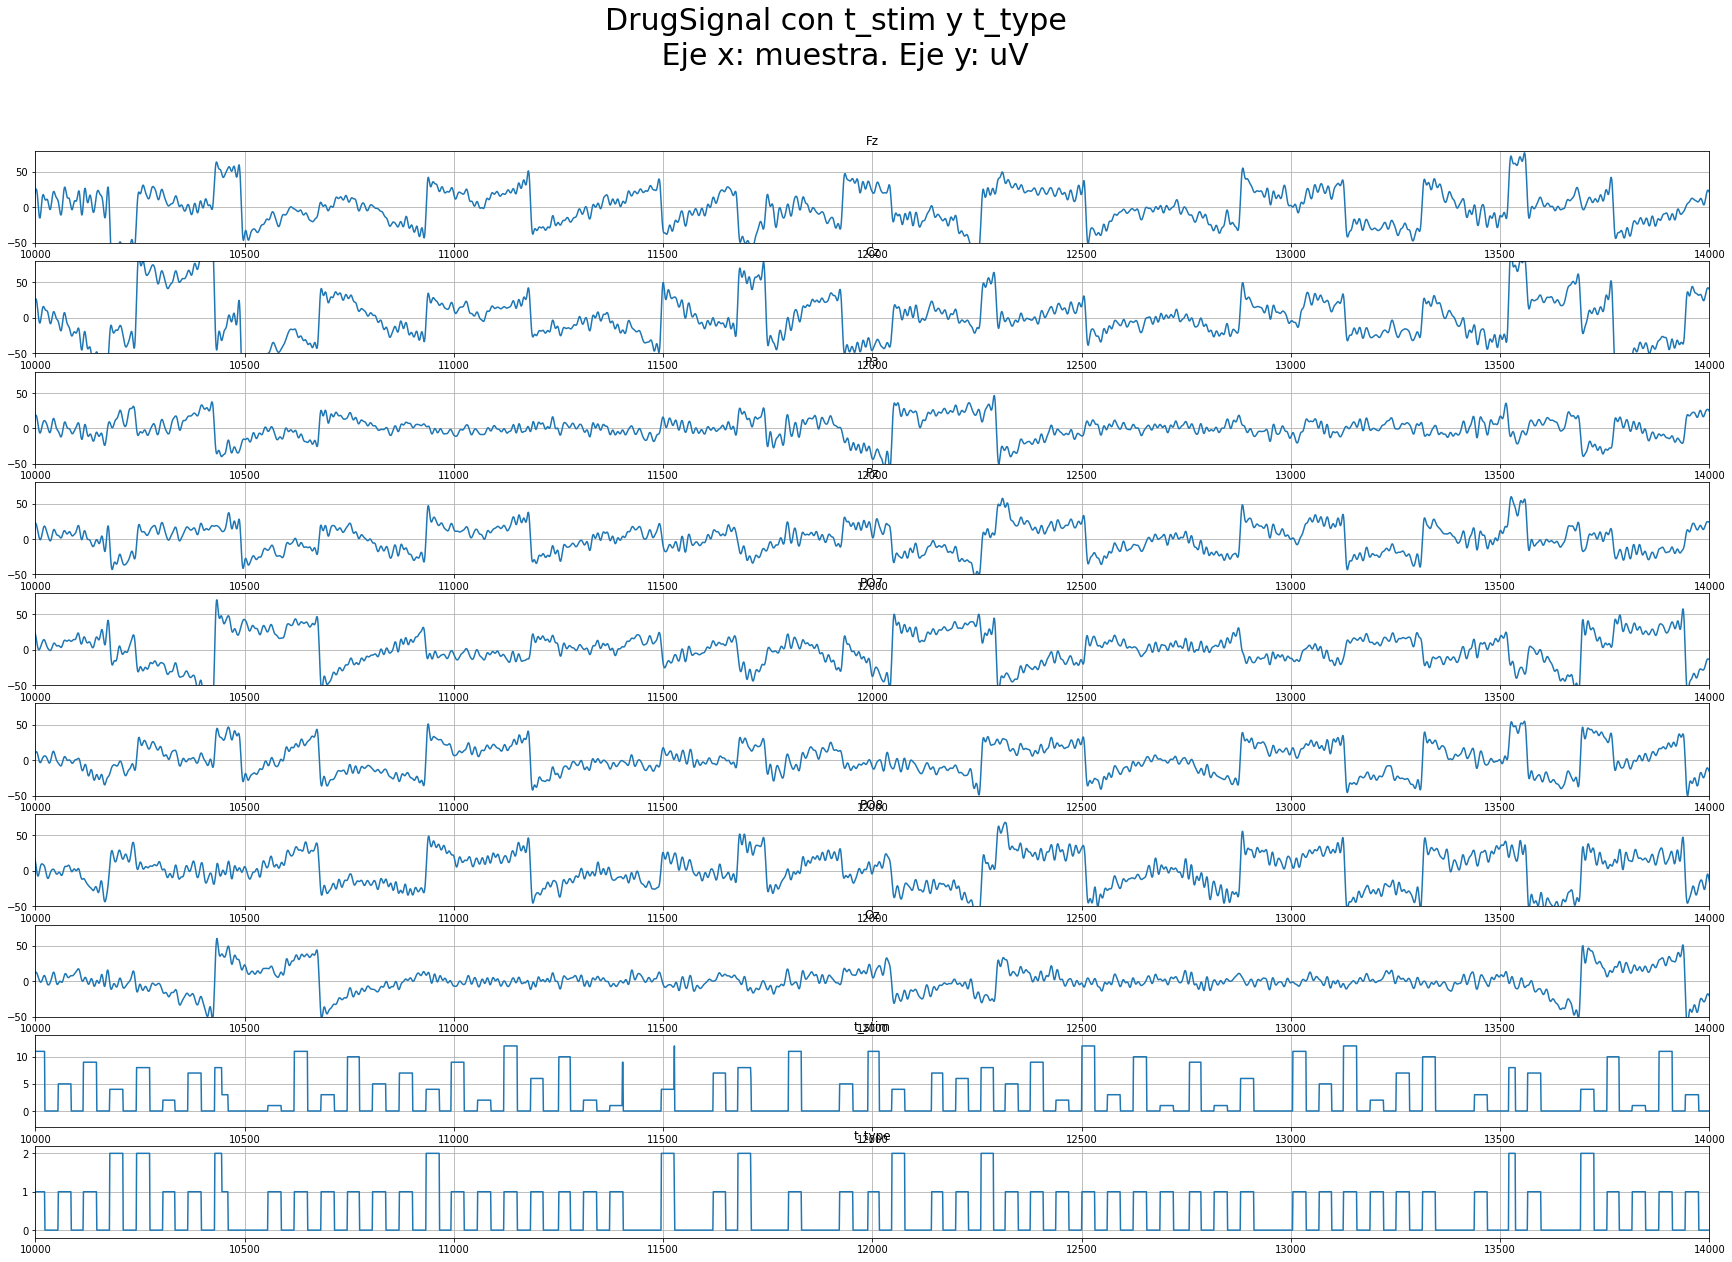

In [45]:
#-----------------------------------------------------------------------
# Gráficas de la señal con el ERP agregado y con *t_stim y t_type*.   
# La primera gráfica muestra el resultado general.    
# La segunda gráfica es cada una de las señales en un periodo de tiempo determinado.  
#-----------------------------------------------------------------------

#plt.figure(figsize=(30,8))                                     
#axes = plt.gca()
#for i in range(0,9):
#    plt.plot(df_signal_events['sample'], df_signal_events.iloc[:,i])
#axes.set_title('DrugSignal con t_stim y t_type'), axes.title.set_size(30)
#axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
#axes.xaxis.label.set_size(20), axes.yaxis.label.set_size(20)
#plt.savefig("./a_images/DrugSignal_p300subject25[data][0][0][0].jpg")
#plt.grid(), plt.show()
                 

xlim_general=([10000,14000])
ylim_general=([-50,80])
eje_x_sample=df_signal_events['sample']
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=10, ncols=1,figsize=(30,20))
fig.suptitle("DrugSignal con t_stim y t_type  \n Eje x: muestra. Eje y: uV ", fontsize=30)

ax0.plot(eje_x_sample, df_signal_events.iloc[:,0], label='0') 
ax0.set_xlim(xlim_general), ax0.set_ylim(ylim_general), ax0.set_title(df_signal_events.columns[0]), ax0.grid()

ax1.plot(eje_x_sample, df_signal_events.iloc[:,1], label='1')
ax1.set_xlim(xlim_general), ax1.set_ylim(ylim_general), ax1.set_title(df_signal_events.columns[1]), ax1.grid()

ax2.plot(eje_x_sample, df_signal_events.iloc[:,2], label='2')
ax2.set_xlim(xlim_general), ax2.set_ylim(ylim_general), ax2.set_title(df_signal_events.columns[2]), ax2.grid()

ax3.plot(eje_x_sample, df_signal_events.iloc[:,3], label='3')
ax3.set_xlim(xlim_general), ax3.set_ylim(ylim_general), ax3.set_title(df_signal_events.columns[3]), ax3.grid()

ax4.plot(eje_x_sample, df_signal_events.iloc[:,4], label='4')
ax4.set_xlim(xlim_general), ax4.set_ylim(ylim_general), ax4.set_title(df_signal_events.columns[4]), ax4.grid()

ax5.plot(eje_x_sample, df_signal_events.iloc[:,5], label='5')
ax5.set_xlim(xlim_general), ax5.set_ylim(ylim_general), ax4.set_title(df_signal_events.columns[5]), ax5.grid()

ax6.plot(eje_x_sample, df_signal_events.iloc[:,6], label='6')
ax6.set_xlim(xlim_general), ax6.set_ylim(ylim_general), ax6.set_title(df_signal_events.columns[6]), ax6.grid()

ax7.plot(eje_x_sample, df_signal_events.iloc[:,7], label='7')
ax7.set_xlim(xlim_general), ax7.set_ylim(ylim_general), ax7.set_title(df_signal_events.columns[7]), ax7.grid()

ax8.plot(eje_x_sample, df_signal_events.iloc[:,8], label='8')
ax8.set_xlim(xlim_general), ax8.set_ylim([-3,14]), ax8.set_title(df_signal_events.columns[8]), ax8.grid()

ax9.plot(eje_x_sample, df_signal_events.iloc[:,9], label='9')
ax9.set_xlim(xlim_general), ax9.set_ylim([-0.2,2.2]), ax9.set_title(df_signal_events.columns[9]), ax9.grid()

plt.show()

In [ ]:
#========================================================================
# getstims recibe dos argumentos: eeg_mne y eeg_events. eeg_mne debe ser un objeto de tipo MNE Raw o Epochs, 
# mientras que eeg_events debe ser un objeto que contenga los eventos relacionados con la señal EEG.
# La función utiliza la biblioteca MNE de Python para encontrar los eventos en la señal EEG y crear epochs de 0 a 0.8 segundos de duración, 
# a partir de los eventos encontrados. Luego, la función extrae las marcas de tiempo de los eventos y las devuelve como una lista junto 
# con los epochs.

# En resumen, la función getstims extrae los estímulos de una señal EEG y devuelve una lista de epochs y las marcas de tiempo de los eventos 
# relacionados con la señal.

def getstims(eeg_mne, eeg_events):
    '''
    Get the stimulations.  These are the FLASHINGS of rows and columns.
    '''
    tmin = 0
    tmax = 0.8
    reject = None
    event_times = mne.find_events(eeg_events, stim_channel='t_stim',shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
    event_id = {'Row1':1,'Row2':2,'Row3':3,'Row4':4,'Row5':5,'Row6':6,'Col1':7,'Col2':8,'Col3':9,'Col4':10,'Col5':11,'Col6':12}


    epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                    baseline=None, reject=reject, preload=True,
                    verbose=True, reject_by_annotation=None)


    stims = event_times[:,-1]

    return [epochs,stims]

stimepochs, stims = getstims(eeg, eeg)                                  # Época de estimulación.
stimepochs



#========================================================================
# ChatGPT:
# La función getlabels recibe tres argumentos: eeg_mne, eeg_events y event_id. eeg_mne debe ser un objeto de tipo MNE Raw o Epochs, 
# mientras que eeg_events debe ser un objeto que contenga los eventos relacionados con la señal EEG.
# La función utiliza la biblioteca MNE de Python para encontrar los eventos en la señal EEG y crear epochs de 0 a 0.8 segundos de duración, 
# a partir de los eventos encontrados. Luego, la función extrae las marcas de tiempo de los eventos y las devuelve como una lista junto 
# con los epochs.

# En resumen, la función getstims extrae los estímulos de una señal EEG y devuelve una lista de epochs y las marcas de tiempo de los eventos 
# relacionados con la señal.


def getlabels(eeg_mne, eeg_events, event_id):
    '''
    Get the hit/no hits labels.  These are the FLASHINGS of rows and columns but selected if they are the ones that will
    trigger the P300 response or not.
    '''
    #event_id = { 'first':1, 'second':2 }
    #baseline = (0.0, 0.2)
    #reject = {'eeg': 70 * pow(10,6)}
    tmin = 0
    tmax = 0.8
    reject = None
    event_times = mne.find_events(eeg_events, stim_channel='t_type', shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
    epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                    baseline=None, reject=reject, preload=True,
                    verbose=True, reject_by_annotation=None)
    labels = epochs.events[:, -1]
    return [epochs, labels]

epochs, labels = getlabels(eeg, eeg, {'first':1})


epocked = epochs.average()
epocked.plot(window_title='NoHit Averaged Signals')


epochs, labels = getlabels(eeg, eeg, {'second':2})

epocked = epochs.average()
epocked.plot(window_title='Hit Averaged Signals')

epochs, labels = getlabels(eeg, eeg, { 'first':1, 'second':2})


# Downsample the original FS=250 Hz signal to >>> 20 Hz
#epochs.resample(20, npad="auto")
#stimepochs.resample(20, npad="auto")
repetitions=120

# %%
# This is Single Flashing Classification attempt.
from sklearn.preprocessing import  StandardScaler                   # Transforma los valores de los datos en un formato estándar.
from sklearn.linear_model import LogisticRegression                 # Regresión logística.
from sklearn import svm                                             # SVM.
from sklearn.pipeline import make_pipeline                          # ¿No lo usa?

from sklearn.model_selection import StratifiedKFold                 # Validador cruzado de K-Folds estratificado.
from sklearn.metrics import classification_report, confusion_matrix # Estadísticas de resultados.
from sklearn.preprocessing import MinMaxScaler                      # Transforme las funciones escalando cada función a un rango determinado.

# import a linear classifier from mne.decoding
from mne.decoding import LinearModel

import matplotlib.pyplot as plt

clf = LogisticRegression(solver='lbfgs')
scaler = StandardScaler()

# create a linear model with LogisticRegression
model = LinearModel(clf)

# Get the epoched data (get only the data columns)
eeg_data = epochs.get_data().reshape(len(labels), -1)
eeg_data = eeg_data[:,0:epochs.get_data().shape[2]*1]
#eeg_data[labels==2] = erptemplate1[:201,0]
#eeg_data[labels==1] = erptemplate1[:201,0]

#eeg_data[labels==2] = np.zeros((eeg_data.shape[1],))
#eeg_data[labels==1] = np.ones((eeg_data.shape[1],))

#labels = np.random.permutation(labels)

# fit the classifier on MEG data
X = scaler.fit_transform(eeg_data)

model.fit(X[0:2800], labels[0:2800])

preds = model.predict(X[2800:])

# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels[2800:], preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels[2800:], preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))

In [47]:
# In[1]:   Average classification x trial (unbalanced)
# Este dataset es un dataset de calibración. El registro de EEG corresponde a un experimento del Speller
# de 35 letras (7 palabras de 5 letras).   Cada una de las letras consiste en 10 repeticiones de la intensificación 
# de los 12 estímulos distintos, siendo cada estímulo el FLASHING de una de las 6 filas o 6 columnas.
# Cada vez que se repite, se hace una permutación de los 12.
# En cada una de esos 12 estímulos, dos, uno correspondiente a una fila y a una columna, corresponden 
# a la letra que la persona está prestando atención y la idea es que el sistema descubra que letra es.

# Primero tengo que agarrar la lista de labels y asignar a los 420 (35x12)
# el label que le corresponde a cada uno.  Es decir de los primeros 12, 10
# son no hits y 2 hits.

# hlbls tiene pares (r,c) que representan la fila y la columna donde está la letra
# que la persona tiene que elegir. 
hlbls = []
hpreds = []
classlabels=np.asarray([])
for trial in range(0,35):
    a=np.zeros((12*10,2))
    a[:,0] = stims[0+120*trial:0+120*trial+120]
    a[:,1] = labels[0+120*trial:0+120*trial+120]

    b=np.zeros((12,1))

    for i in range(1,13):
        b[i-1] = np.unique(a[a[:,0]==i,1])

    for i in range(0,6):
        if (b[i]==2):
            r = i+1

    for i in range(6,12):
        if (b[i]==2):
            c = i+1

    classlabels = np.append( classlabels, b )

    assert (r!=0 and c!=0), 'Error %d,%d' % (r,c) 
    hlbls.append( (r,c) )

# In[1]:  
def SpellMeLetter(row, col):
    spellermatrix = [ ['A','B','C','D','E','F'],
                    [ 'G','H','I','J','K','L'],
                [ 'M','N','O','P','Q','R'],
                [ 'S','T','U','V','W','X'],
                [ 'Y','Z','1','2','3','4'],
                [ '5','6','7','8','9','_'] ]

    return spellermatrix[row-1][col-1-6]

# Esta es la frase de 7 palabras de 5 letras que la persona tiene que producir.
for i in range(0,35):
    print(SpellMeLetter(hlbls[i][0],hlbls[i][1]),end='')

print()
# In[1]: 
# Luego necesito calcular los 420 averaging (de repetitions)
# Finalmente aprendo con 180 y me fijo si predigo los 240
# De los 240 adivino 20 letras (de a pares) y con eso calculo la performance

def getaverageepoch(singleepoch):
    '''
    Build the epochs based on each stimulation (1-12), and put all the epochs togheter.
    '''
    for trial in range(0,35):
        epochstrial = singleepoch[0+repetitions*trial:repetitions*trial+repetitions]

        epochr1 = epochstrial['Row1']
        epochr2 = epochstrial['Row2']
        epochr3 = epochstrial['Row3']
        epochr4 = epochstrial['Row4']
        epochr5 = epochstrial['Row5']
        epochr6 = epochstrial['Row6']

        epochc1 = epochstrial['Col1']
        epochc2 = epochstrial['Col2']
        epochc3 = epochstrial['Col3']
        epochc4 = epochstrial['Col4']
        epochc5 = epochstrial['Col5']
        epochc6 = epochstrial['Col6']

        if (trial==0):
            epochs_data = np.array([epochr1.average().data])
        else:
            epochs_data = np.concatenate((epochs_data, [epochr1.average().data]), axis=0)

        epochs_data = np.concatenate((epochs_data, [epochr2.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochr3.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochr4.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochr5.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochr6.average().data]), axis=0)

        epochs_data = np.concatenate((epochs_data, [epochc1.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochc2.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochc3.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochc4.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochc5.average().data]), axis=0)
        epochs_data = np.concatenate((epochs_data, [epochc6.average().data]), axis=0)

    # There are 420 epochs, which correspond to 35 letters, in groups of 12.
    events=np.array([np.arange(420),np.zeros(420), classlabels])
    events = events.T
    events = events.astype(int)

    tmin = 0
    tmax = 0.8
    event_id = { 'first':1, 'second':2 }
    info = mne.create_info(ch_names, 250, ch_types=ch_types)
    custom_epochs = mne.EpochsArray(epochs_data, info, events, tmin, event_id) 

    return custom_epochs

# avepochs contains all the 420 averaged epochs, 7 letters of 5, with 12 each.
custom_epochs = getaverageepoch(stimepochs)


# In[1]: 
# Performs the final classification, the one that allows to produce the spelled letters.
print('Performance Classification of Averaged Epochs')
clf = LogisticRegression(solver='lbfgs')
scaler = StandardScaler()

# create a linear model with LogisticRegression
model = LinearModel(clf)

training = range(0,180)
test = range(180,420)

eeg_data = custom_epochs.get_data()

eeg_data = eeg_data.reshape(420, -1)
eeg_data = eeg_data[:,0:201]

#eeg_data[classlabels==2] = np.zeros((eeg_data.shape[1],))
#eeg_data[classlabels==1] = np.ones((eeg_data.shape[1],))

#X = scaler.fit_transform(eeg_data)

X = eeg_data

cf = clf.fit(X[training], classlabels[training])

classpreds = np.empty ((420,2))

classpreds[test,:] = clf.predict_proba(X[test])

hpreds = []

for trial in range(15,35):
    #print('Row')
    for i in range(0,6):
        preds = classpreds[trial*12+i]
        #print ( preds[1] )
        labels = classlabels[trial*12+i]

    #print (  np.argmin( classpreds[trial*12+0:trial*12+6]))
    r = np.argmax( classpreds[trial*12+0:trial*12+6,1])+1
    

    #print('Col')
    for i in range(6,12):
        preds = classpreds[trial*12+i]
        #print ( preds[1] )
        labels = classlabels[trial*12+i]

    #print (  np.argmin( classpreds[trial*12+6:trial*12+12]))
    c = np.argmax( classpreds[trial*12+6:trial*12+12,1])+1

    hpreds.append( (r,c) )

# In[1]: 
for i in range(15,35):
    print(SpellMeLetter(hlbls[i][0],hlbls[i][1]),end='')

print()

# In[1]: 
for i in range(15,35):
    print(SpellMeLetter(hpreds[i-15][0],hpreds[i-15][1]),end='')

print()


# %%
for i in range(0,12):
    plt.figure(figsize=(9, 3))
    plt.plot(eeg_data[i])
    plt.show()
# %%

# Classification report
target_names = ['nohit', 'hit']

report = classification_report(classlabels[test], clf.predict(X[test]), target_names=target_names)
print(report)

cm = confusion_matrix(classlabels[test], clf.predict(X[test]) )
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))

ValueError: could not broadcast input array from shape (2,) into shape (1,)